# NLP Application with ML

## Classification of Tweets Data

### The Data

Source: https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (9,4)
pd.set_option('display.max_columns', 50)

/Users/kadiryildirim/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# localinizde bu dosyaları bir kere indrmeniz yeterlidir.
# colab'te her çalıştığınızda tekrar yüklemeniz gerekir.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\walke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\walke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\walke\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\walke\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
df = pd.read_csv("airline_tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# check duplicates
sum(df.duplicated())

36

In [4]:
# drop them and reset index
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

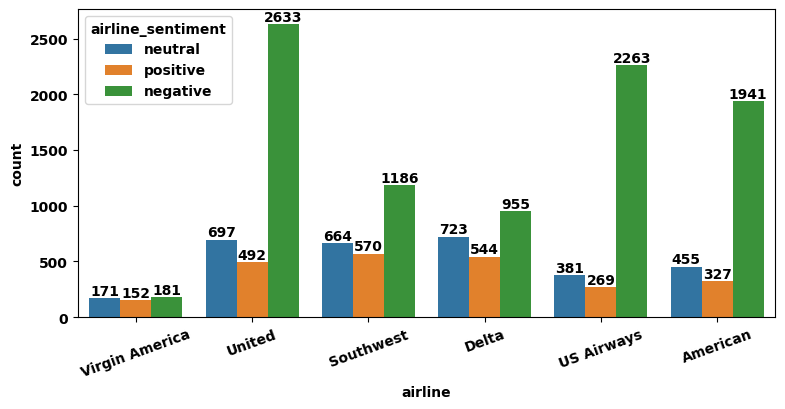

In [6]:
ax = sns.countplot(data = df, x ="airline", hue = "airline_sentiment")
for p in ax.containers:
    ax.bar_label(p)
plt.xticks(rotation =20);

# Havayolu şirketleri bazında alınan yorum sayılarını görselleştiriyoruz.

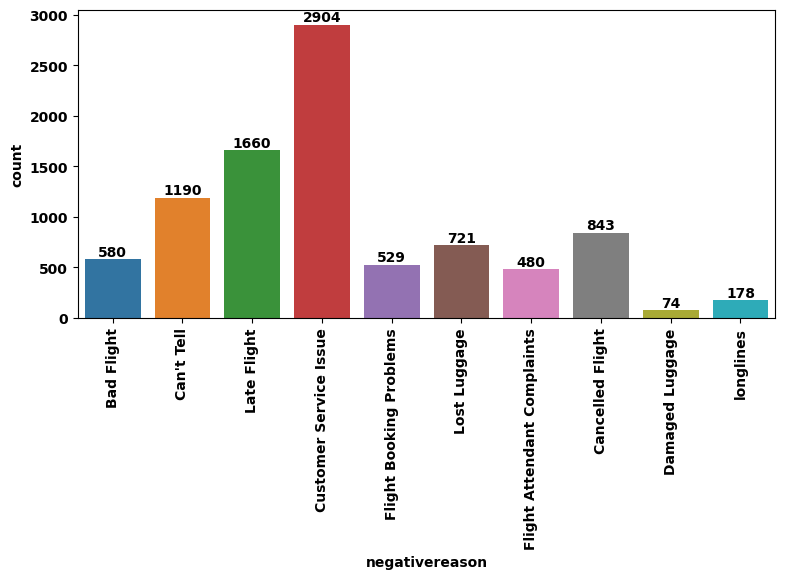

In [7]:
ax = sns.countplot(data =df, x ="negativereason")
ax.bar_label(ax.containers[0])
plt.xticks(rotation =90);

# Olumsuz yorum sebeplerinin sayısını görselleştiriyoruz.

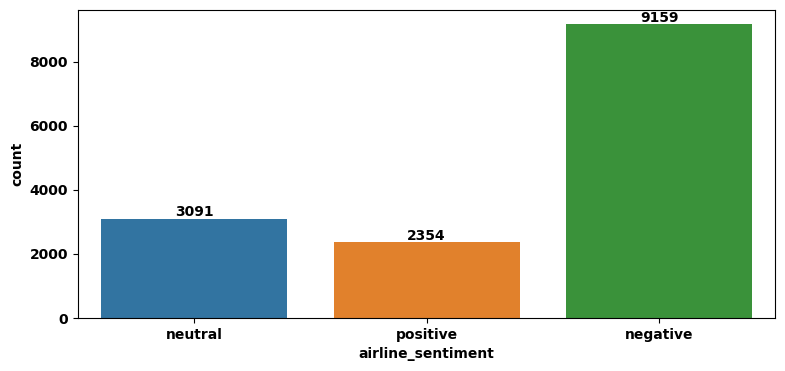

In [8]:
ax = sns.countplot(data =df, x = "airline_sentiment")
ax.bar_label(ax.containers[0]);

# classlarımızın sayısını görselleştiriyoruz. target classimiz negative olacak

In [9]:
df["airline_sentiment"].value_counts(normalize=True)

negative    0.627157
neutral     0.211654
positive    0.161189
Name: airline_sentiment, dtype: float64

## Cleaning Data

In [5]:
# get a deep copy
df2 = df.copy()

In [6]:
df2["text"].head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

### Cleaning URL, Tags, Mentions for Tweets

In [8]:
import re

# some examples for sub and regex 
s = "http\\:www.mynet.com #lateflight @airlines"
s = re.sub("http\S+", "", s)
s

# \S boşluk hariç diğer tüm karakterleri temsil eder.
# http\S+, http ile başlayan ve http'den sonra boşluk hariç en az bir veya daha fazla karakter ihtiva eden paternleri temsil 
# eder.
# http\S*, http ile başlayan ve http'den sonra boşluk hariç en az sıfır veya daha fazla karakter ihtiva eden paternleri temsil
# eder.
# regex'in sub fonksiyonu kendisine verilen text içirisinde aradığımız paternlerini bulup silmemize veya istediğimiz bir 
# karakter/karakterlerle değiştirmemizi sağlar.
# re.sub("http\S+", "", s) kodu s değişkenine atadığımız text içerisinde http ile başlayan ve http'den sonra boşluk hariç en az
# bir veya daha fazla karakter ihtiva eden paternleri bulur ve siler.

# re.sub("http\S+", "a", s) kodu s değişkenine atadığımız text içerisinde http ile başlayan ve http'den sonra boşluk hariç en az
# bir veya daha fazla karakter ihtiva eden paternleri bulur ve a karakteri ile değiştirir.

' #lateflight @airlines'

In [13]:
s = re.sub("#\S+", "", s)
s

# tag'i temizliyoruz. Ancak gördüğünüz gibi text'in başında bir boşluk karakteri oluştu. strip() ile temizleriz

' @airlines'

In [14]:
s = re.sub("@\S+", "", s)
s.strip()

# mentionı temizliyoruz.

# \S boşluk hariç diğer tüm karakterleri temsil ettiğinden yukarıda gördüğünüz üzere boşluklara bir işlem yapmaz. Bu sebeple 
# textimizin başında veya sonunda kalan boşluk karakterlerini strip() fonksiyonu ile temizliyoruz.

''

In [10]:
# * ile kullanmak daha mantikli
aa = "http\\:www.mynet.com #lateflight @airlines"
aa = re.sub("http\S*", "", s).strip()
aa

'#lateflight @airlines'

In [11]:
stop_words = stopwords.words('english')

for i in ["not", "no"]:
        stop_words.remove(i)

In [12]:
def cleaning(data):
    
    import re
    
    #1. Removing URLS
    data = re.sub('http\S*', '', data).strip()
    data = re.sub('www\S*', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S*', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S*', '', data).strip()
    
    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")
    
    #5. Tokenize
    text_tokens = word_tokenize(data.lower())
    
    #6. Remove Puncs and numbers
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #7. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #8. lemmatization
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
       
    #9. joining
    return " ".join( text_cleaned)

In [13]:
cleaning_text = df2["text"].apply(cleaning)
cleaning_text.head()

# textimi temizleyip cleaning_text değişkenine atıyorum. Notebookun sonunda WordCloud görselleştirmesinde kullanacağız.
# temizleme islemini df icin vectorizerda yapacagiz, bu clening_text en son kullanmak icin

0                                                 said
1         plus youve added commercial experience tacky
2         didnt today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
Name: text, dtype: object

## Features and Label

In [14]:
df2 =df2[["airline_sentiment", "text"]]
df2.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## Train Test Split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = df2["text"]
y = df2["airline_sentiment"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

## Vectorization

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
vectorizer = CountVectorizer(preprocessor=cleaning, min_df=3, max_df=0.9) # ngram_range=(1,3), max_features= 1500
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

# n_gramli ve n_gramsiz deneyerek skor alir ve hangisi iyise onunla devam ederiz. Bu datada ngram_range'siz skorlar farketmedi
# ngram_range(1,3) bir range, yani sadece 3lü yapmaz, 1li,2li,3lü tek tek yapar. 
# Ama bu range'i cok da buyutmemek lazim cunku datayii cok wide yapar

# preprocessor hyper-parametresine yukarıda tanımladığımız "cleaning" fonksiyonunu vererek temizlik işlemini CountVectorizer
# dönüşüm algortiması içerisinde yaptırabiliyoruz. Dolayisiyla tanimladigimiz cleaning fonksiyonunu disarda tekrar 
# calsitirmaya gerek yok
# min_df = 3    --> corpusumda 3'den daha az document'da (yorumda) geçen tokenleri ignore et. 
# max_df = 1000 --> corpusumda 1000'den daha fazla document'da (yorumda) geçen tokenleri ignore et. 
# cok az gecenler ve cok fazla gecenleri temizlemekte sikinti yok. max_df'i float olarak vermek best practice. oran oluyor, eger 1.0
# yerine 1 yazarsak 1den fazla yorumda gecen tum tokenlari ignore eder. dikkat!!

# max_df = 0.95 --> corpusumdaki yorumların en az %95'inde geçen tokenleri ignore et
# min_df olarak 3,4,5 gibi, max_df 0.90, 0.95 ve üzeri değerler tercih edilebilir.

# max_features = 1500 --> corpusumda en sık kullanılan ilk 1500 feature (tokeni) dikkate al diğerlerini ignore et.
# cok risklidir max_features. orn bu ornekte ilk 1500 disindaki tum tokenlari atar ve skorlarimizi cok olumsuz
# etkileyebilir. kullanmamak daha mantikli olabilir

# ngram, textimizdeki kalıpların (isim tamlaması, sıfat tamlaması vb) daha iyi öğrenilmesi için kullanılır. default 1,1
# "Çok güzel bir TV" yorumu için;
# ngram = 1 olarak tüm tokenler 1'er 1'er ayrışır. Çok, güzel, bir, TV
# ngram = 2 olarak tüm tokenler 2'şer 2'şer ayrışır. Çok güzel, güzel bir, bir TV
# ngram = 3 olarak tüm tokenler 3'er 3'er ayrışır. Çok güzel bir, güzel bir TV
# ngram_range = (1, 3) tüm tokenler ngram 1, 2 ve 3'e göre 1'er 1'er, 2'şer 2'şer ve 3'er 3'er tokenlerine ayrılır
# ngram_range = (1, 4) tüm tokenler ngram 1, 2, 3 ve 4'e göre 1'er 1'er, 2'şer 2'şer, 3'er 3'er ve 4'er 4'er tokenlerine ayrılır

In [21]:
X_train_count.toarray() # sadece gormek icin, projelerde ve gercek hayatta kullanilmaz

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
pd.DataFrame(X_train_count.toarray(), columns = vectorizer.get_feature_names_out())

,aa,aadvantage,abc,ability,able,aboard,abq,absolute,absolutely,absurd,abt,abysmal,ac,accept,acceptable,accepted,accepting,access,accident,accommodate,accommodating,accommodation,accomplished,according,account,...,yay,yea,yeah,year,yell,yelled,yelling,yep,yes,yesterday,yet,yo,york,youd,youll,young,youre,youve,yr,yuma,yup,yvr,yyz,zero,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11680,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11681,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Model Comparisons - Vectorization

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score

In [24]:
def eval(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(confusion_matrix(y_test, y_pred))
    print("Test_Set")
    print(classification_report(y_test,y_pred))
    print("Train_Set")
    print(classification_report(y_train,y_pred_train))
    

## Naive Bayes

Naive Bayes ismi, algoritmanın temel varsayımı olan "featureların/tokenlerin birbirinden bağımsız olması" ("naive") nedeniyle verilmiştir. Bu varsayım, gerçek dünya uygulamalarındaki featurelar/tokenler arasındaki ilişkileri yok sayar ve her feature/token için ayrı ayrı olasılıkları hesaplar. Bu varsayım, gerçek hayatta genellikle geçerli olmadığından, algoritmanın doğruluk oranını düşürebilir, ancak yine de Naive Bayes algoritması çok yaygın olarak kullanılır ve çok iyi sonuçlar verir.

Bayes Teoremi, olasılık kuramının temel prensiplerinden biridir. 

Koşullu olasılıkta denen Bayes Teoremi, bir olayın gerçekleşme olasılığının, o olayın gerçekleşmesi için gerekli olan diğer tüm olayların gerçekleşme olasılıkları üzerinden hesaplamak için kullanılan matematiksel bir kuramdır.

Örneğin, P(Süper Telefon, kötü kargo | Olumlu) --> Olumlu bir yorumda, telefonun süper ancak kargonun kötü olma olasılığı.

veya, P(Olumlu | Süper Telefon, kötü kargo) --> Telefonun süper ancak kargonun kötü olduğu bir yorumun olumlu olma olasılığı.

Örneğin, P(Süper Telefon, kötü kargo | Olumlu) --> Olumlu bir yorumda, telefonun süper ancak kargonun kötü olma olasılığını hesaplayabilmemiz için corpusdaki olumlu yorumlarda "süper", "telefon", "kötü" ve "kargo" tokenlerinin geçme olasılığı ile corpusta bir yorumun olumlu olma olasılığını bilmemiz gerekir. Bu bilgiler olmadan bu yorumun olumlu olma olasılığını hesaplayamayız.

In the context of Natural Language Processing (NLP), "naive Bayes" refers to a simple and widely used classification algorithm. It is based on Bayes' theorem, which is a probability theorem that calculates the likelihood of an event based on prior knowledge or evidence.

"Naive" in the term "naive Bayes" indicates that the algorithm makes a simplifying assumption that the features (or attributes) of the input data are independent of each other, which may not be true in reality. Despite this simplification, the naive Bayes algorithm often performs well in practice and is particularly useful for text classification tasks in NLP.

In very simple terms, the naive Bayes algorithm works as follows:

- Training: The algorithm learns from a labeled dataset, where each instance is associated with a class label. In text classification, for example, the input data could be a collection of documents, and the class labels could be categories like "spam" or "not spam."
- Feature Extraction: The algorithm extracts relevant features from the input data. In text classification, these features could be word frequencies, presence or absence of certain words, or other linguistic properties.
- Calculating Probabilities: The algorithm calculates the probabilities of each feature occurring in each class. It computes the likelihood of a specific feature given a class label based on the training data.
- Classification: Given a new, unseen input instance, the algorithm uses the probabilities calculated in the previous step to predict its class label. It applies Bayes' theorem to estimate the probability of the instance belonging to each class and selects the class with the highest probability as the predicted label.

The naive Bayes algorithm is known for its simplicity, computational efficiency, and ability to handle high-dimensional data such as text. However, its "naive" assumption of feature independence can limit its performance when features are actually dependent on each other. Nonetheless, naive Bayes classifiers are widely used in various NLP tasks, such as sentiment analysis, spam detection, and document categorization, due to their effectiveness and ease of implementation.

https://medium.com/analytics-vidhya/na%C3%AFve-bayes-algorithm-5bf31e9032a2

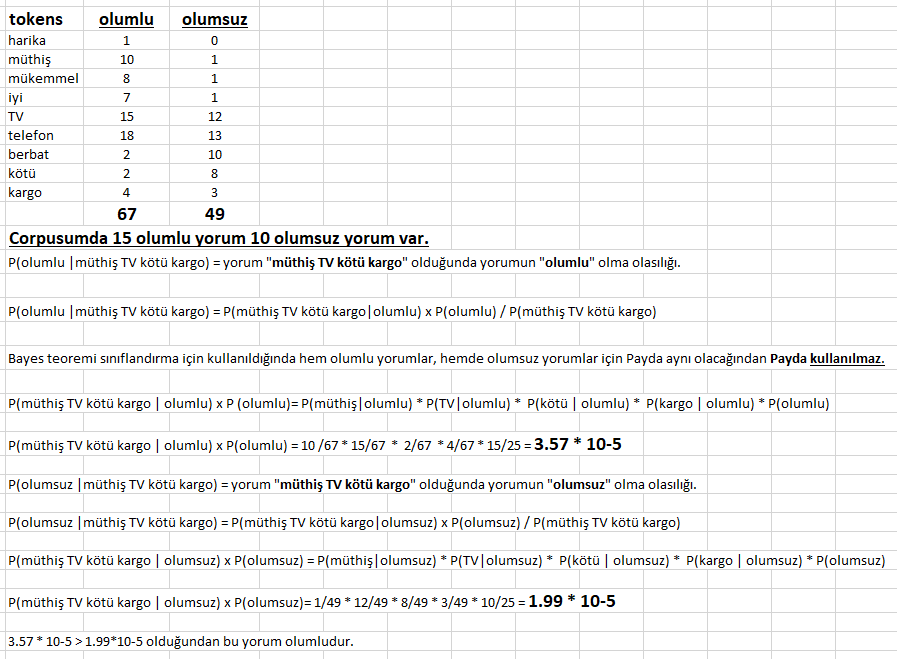

### Alpha Hyper-Parameter for Naive Bayes

Alpha (Laplace smoothing), also known as add-one smoothing or Laplace add-one smoothing, is a technique used in probability and statistics, particularly in the context of language modeling and naive Bayes classification. It is a way to handle the problem of zero probabilities or unseen events in probability calculations.

In simple terms, Laplace smoothing is applied to avoid situations where a probability calculation would result in zero when estimating the likelihood of an event that hasn't been observed in the training data. It addresses the issue of overfitting and helps make the model more robust.

Alpha Laplace smoothing involves adding a small constant (typically 1) to the numerator and a scaled constant (the number of possible outcomes) to the denominator when estimating probabilities. This "smoothing" operation redistributes probability mass from observed events to unseen events, ensuring that no probability estimate becomes zero.

Alpha Laplace smoothing is a simple and widely used technique to handle zero probabilities in various statistical models, particularly in text classification tasks using naive Bayes algorithms or language modeling applications.

Naive Bayeste kullanacagimiz tek parametre alpha. Bir kelimenin olasiliginin sifir cikmasina izin vermiyor bu parametre; sifira cok yakin olsa da sifir degildir. dolayisiyla olasiliklardan birisi sifir cikarsa, alpha katsayisi ile ornegin alphayi 1 yaparak onu corpustaki unique token sayisi ile carparak o olasiliga ekliyoruz. Alpha'ya laplace smoothing de denir.

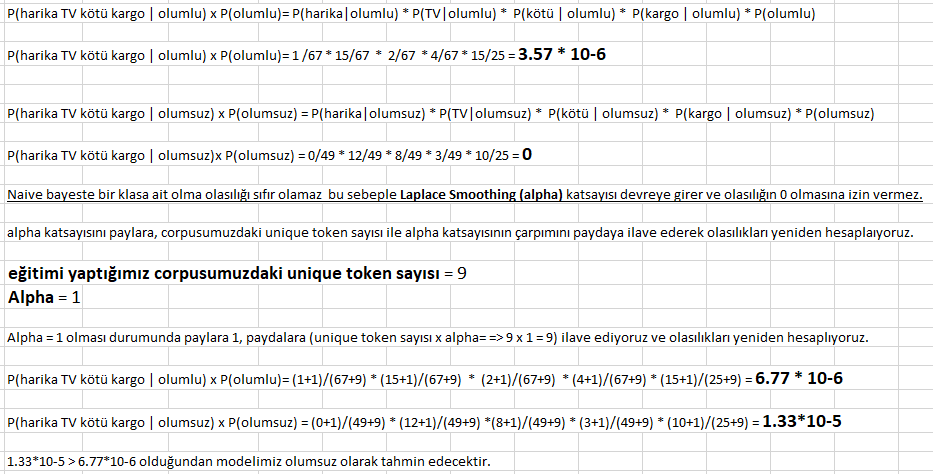

In [26]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB # BernoulliNB for binary model


In [27]:
nb = MultinomialNB(alpha=10) # 1den baslayarak trial error ile 10u best alpha bulduk. amac recall'u iyilestirmek asagida
nb.fit(X_train_count,y_train)

# Her nekadar multiclass datalar için MultinomialNB, binary datalar için de BernoulliNB tavsiye ediliyor olsa da. Datamızın 
# türü ne olursa olsun ikisini de deneyip hangisinde iyi sonuçlar alıyorsak onunla devam edeceğiz.

# Gaussian algortiması NLP dataları için tavsiye edilmez.

# Alpha hyper_parametresi genellikle 0 ile 1 arasında düzenlenmesi tavsiye edilse de data özelinde daha yüksek değerler
# tercih edilebilir. Bu değer büyüdükçe precision-recall dengesini bozabilir bu da underfitinge sebep olabilir.


# alpha hyper-parametresini overfiting'i kontrol için kullanabiliriz. Ancak alpha değerini çok büyütmek model performansımızı
# bozacağından overfitingi gidermek için sample_weight/class_weight'de kullanabiliriz.

MultinomialNB(alpha=10)

Normalde burada gridsearch de yapmamiz gerekir.

In [28]:
print("NB MODEL")
eval(nb, X_train_count, X_test_count)
# tamamen negatifi yakalamaya egildigimiz icin alpha ile oynarayarak negatif classinin recallunu artimaya calsiiyoruz

NB MODEL
[[1794   25   13]
 [ 461  132   25]
 [ 258   17  196]]
Test_Set
              precision    recall  f1-score   support

    negative       0.71      0.98      0.83      1832
     neutral       0.76      0.21      0.33       618
    positive       0.84      0.42      0.56       471

    accuracy                           0.73      2921
   macro avg       0.77      0.54      0.57      2921
weighted avg       0.74      0.73      0.68      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.72      0.98      0.83      7327
     neutral       0.80      0.25      0.38      2473
    positive       0.86      0.44      0.58      1883

    accuracy                           0.74     11683
   macro avg       0.79      0.56      0.60     11683
weighted avg       0.76      0.74      0.70     11683



In [29]:
# overfitting kontrolu cv ile
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

scoring = {'accuracy': make_scorer(accuracy_score), # multiclass
            'precision-neg': make_scorer(precision_score, average=None, labels=["negative"]), 
            'recall-neg': make_scorer(recall_score, average=None, labels = ["negative"]),
            'f1-neg': make_scorer(f1_score, average=None, labels = ["negative"])}
# labels'ta sadece tek sinif var, bu nedenle averagei None biraktik., ama birden fazla sinif olursa weight vs diye degistiririz
model = MultinomialNB(alpha=10)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# overfitting yok

test_accuracy          0.714545
train_accuracy         0.733316
test_precision-neg     0.705656
train_precision-neg    0.716520
test_recall-neg        0.978709
train_recall-neg       0.983910
test_f1-neg            0.819999
train_f1-neg           0.829191
dtype: float64

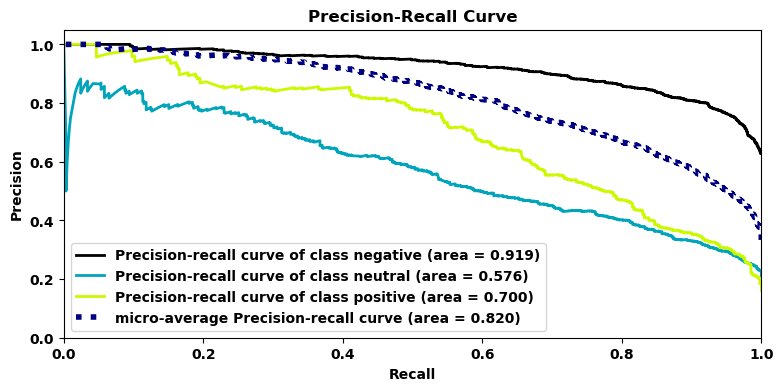

In [33]:
# imbalanced data icin Precision recall
from scikitplot.metrics import plot_roc, plot_precision_recall


model = MultinomialNB(alpha=10)

model.fit(X_train_count, y_train)

y_pred_proba = model.predict_proba(X_test_count)
    
plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [34]:
pd.get_dummies(y_test)

,negative,neutral,positive
1265,0,1,0
2840,0,0,1
9003,0,0,1
61,1,0,0
13690,0,0,1
...,...,...,...
12777,1,0,0
2284,1,0,0
12614,1,0,0
6562,0,1,0


In [35]:
y_pred_proba
# sirayla negatif, notr ve pozitif siniflarini olasiliklari
# gercekle karsilastirmak icin yukarda ytesti get dummies yaptik

array([[9.94520356e-01, 3.56890117e-03, 1.91074294e-03],
       [8.90877776e-02, 1.74935931e-02, 8.93418629e-01],
       [2.18987714e-01, 1.40260090e-01, 6.40752196e-01],
       ...,
       [3.32603050e-01, 5.42710457e-01, 1.24686493e-01],
       [8.93537691e-01, 1.04186232e-01, 2.27607714e-03],
       [9.98580432e-01, 1.10743915e-03, 3.12128650e-04]])

In [36]:
from sklearn.metrics import average_precision_score

y_test_dummies = pd.get_dummies(y_test)

y_pred = nb.predict(X_test_count)

# skorlari kaydedelim en son karsilastirmak icin
nb_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
nb_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
nb_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

In [37]:
average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0]) 
# gercek verilerden negatifi ve dummiesten de yine negatifi, ilk columnu aldik

0.9190427600454487

## Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C = 0.02, max_iter=1000) #class_weight='balanced' # error vermemesi icin max_iter yuksek tut
log.fit(X_train_count,y_train)
# gridsearch yapmadik; manual denemelerle overfittinge karsi mucadele icin C'yi 0.02 yaptik

LogisticRegression(C=0.02, max_iter=1000)

In [31]:
print("LOG MODEL")
eval(log, X_train_count, X_test_count)

LOG MODEL
[[1755   43   34]
 [ 367  214   37]
 [ 180   50  241]]
Test_Set
              precision    recall  f1-score   support

    negative       0.76      0.96      0.85      1832
     neutral       0.70      0.35      0.46       618
    positive       0.77      0.51      0.62       471

    accuracy                           0.76      2921
   macro avg       0.74      0.61      0.64      2921
weighted avg       0.75      0.76      0.73      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.77      0.97      0.86      7327
     neutral       0.76      0.40      0.53      2473
    positive       0.78      0.51      0.62      1883

    accuracy                           0.77     11683
   macro avg       0.77      0.63      0.67     11683
weighted avg       0.77      0.77      0.75     11683



In [32]:
model = LogisticRegression(C = 0.02, max_iter=1000)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]
# overfitting yok

test_accuracy          0.744329
train_accuracy         0.765329
test_precision-neg     0.745790
train_precision-neg    0.761510
test_recall-neg        0.963832
train_recall-neg       0.971111
test_f1-neg            0.840892
train_f1-neg           0.853631
dtype: float64

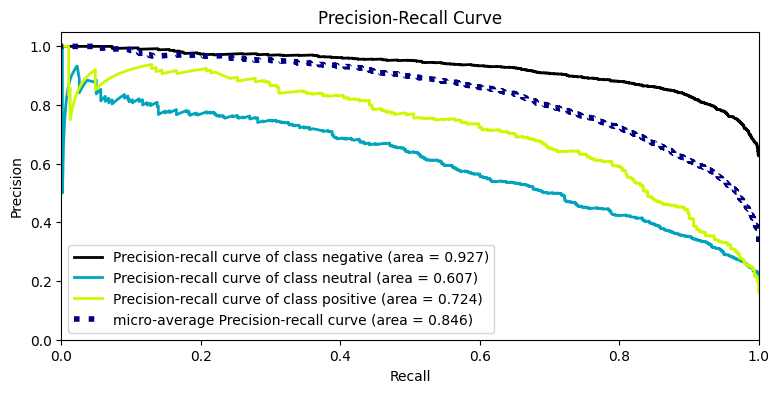

In [33]:
# PRC for the general performance of model
from scikitplot.metrics import plot_roc, plot_precision_recall

model = LogisticRegression(C = 0.02, max_iter=1000)

model.fit(X_train_count, y_train)

y_pred_proba = model.predict_proba(X_test_count)
    
plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [36]:
y_pred = log.predict(X_test_count)
log_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
log_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
log_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

NameError: name 'average_precision_score' is not defined

### Balanced Logistic Regression

In [43]:
log = LogisticRegression(C = 0.02, max_iter=1000, class_weight='balanced')
log.fit(X_train_count,y_train)
# balanced'i kullansak diger siniflari duzeltir ama negatif sinifi kotu kaliyor. sadece gormek icin burasi

LogisticRegression(C=0.02, class_weight='balanced', max_iter=1000)

In [44]:
print("LOG MODEL BALANCED")
eval(log, X_train_count, X_test_count)

LOG MODEL BALANCED
[[1309  427   96]
 [  95  453   70]
 [  34  101  336]]
Test_Set
              precision    recall  f1-score   support

    negative       0.91      0.71      0.80      1832
     neutral       0.46      0.73      0.57       618
    positive       0.67      0.71      0.69       471

    accuracy                           0.72      2921
   macro avg       0.68      0.72      0.69      2921
weighted avg       0.78      0.72      0.73      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.92      0.74      0.82      7327
     neutral       0.51      0.78      0.62      2473
    positive       0.67      0.74      0.71      1883

    accuracy                           0.75     11683
   macro avg       0.70      0.75      0.71     11683
weighted avg       0.80      0.75      0.76     11683



## SVM

In [37]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.01)
svc.fit(X_train_count,y_train)

LinearSVC(C=0.01)

In [38]:
print("SVC MODEL")
eval(svc, X_train_count, X_test_count)

SVC MODEL
[[1710   83   39]
 [ 293  279   46]
 [ 126   57  288]]
Test_Set
              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      1832
     neutral       0.67      0.45      0.54       618
    positive       0.77      0.61      0.68       471

    accuracy                           0.78      2921
   macro avg       0.75      0.67      0.69      2921
weighted avg       0.77      0.78      0.77      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.83      0.96      0.89      7327
     neutral       0.77      0.56      0.65      2473
    positive       0.80      0.64      0.71      1883

    accuracy                           0.82     11683
   macro avg       0.80      0.72      0.75     11683
weighted avg       0.82      0.82      0.81     11683



In [39]:
model = LinearSVC(C=0.01)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.776001
train_accuracy         0.816771
test_precision-neg     0.799346
train_precision-neg    0.828243
test_recall-neg        0.936944
train_recall-neg       0.957994
test_f1-neg            0.862651
train_f1-neg           0.888404
dtype: float64

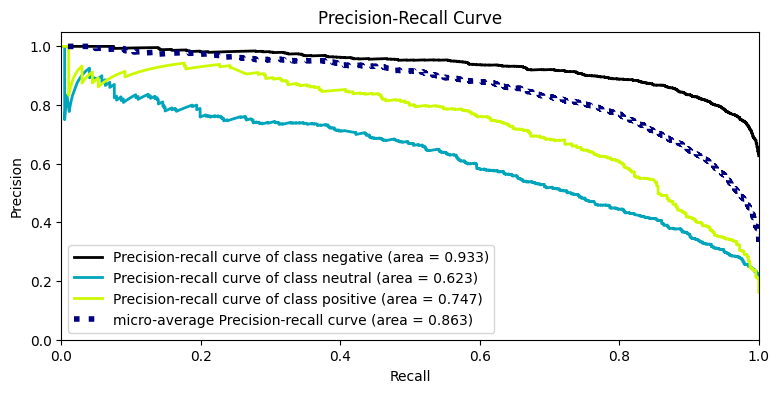

In [40]:
from scikitplot.metrics import plot_roc, plot_precision_recall


model = LinearSVC(C=0.01)

model.fit(X_train_count, y_train)

decision_function = model.decision_function(X_test_count)
# SVM'de pred_proba yok; distance based oldugu icin tercih edlmez, yerine decision function kullanilir
    
plot_precision_recall(y_test, decision_function)
plt.show();

In [41]:
decision_function

array([[ 0.49346035, -0.72248199, -0.91132798],
       [-0.86935299, -0.88252243,  0.7043712 ],
       [-0.86548893, -0.49573777,  0.35373361],
       ...,
       [-0.07269884, -0.17014016, -0.70837666],
       [-0.15920608,  0.00877536, -0.89475103],
       [ 0.91263568, -1.03129063, -1.02944756]])

In [42]:
y_pred = svc.predict(X_test_count)
svc_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
svc_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
svc_AP_neg = average_precision_score(y_test_dummies["negative"], decision_function[:, 0])

NameError: name 'average_precision_score' is not defined

## KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7) # manual cesitli neighbors denedik ama hicbiri iyi sonuc vermedi; KNN bu datada iyi degil
knn.fit(X_train_count,y_train)

KNeighborsClassifier(n_neighbors=7)

In [44]:
print("KNN MODEL")
eval(knn, X_train_count, X_test_count)

KNN MODEL
[[767 996  69]
 [ 62 504  52]
 [ 38 194 239]]
Test_Set
              precision    recall  f1-score   support

    negative       0.88      0.42      0.57      1832
     neutral       0.30      0.82      0.44       618
    positive       0.66      0.51      0.58       471

    accuracy                           0.52      2921
   macro avg       0.62      0.58      0.53      2921
weighted avg       0.72      0.52      0.54      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.92      0.55      0.69      7327
     neutral       0.37      0.86      0.51      2473
    positive       0.71      0.55      0.62      1883

    accuracy                           0.62     11683
   macro avg       0.67      0.66      0.61     11683
weighted avg       0.77      0.62      0.64     11683



In [45]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.521271
train_accuracy         0.631630
test_precision-neg     0.862282
train_precision-neg    0.914052
test_recall-neg        0.439746
train_recall-neg       0.579956
test_f1-neg            0.581554
train_f1-neg           0.709238
dtype: float64

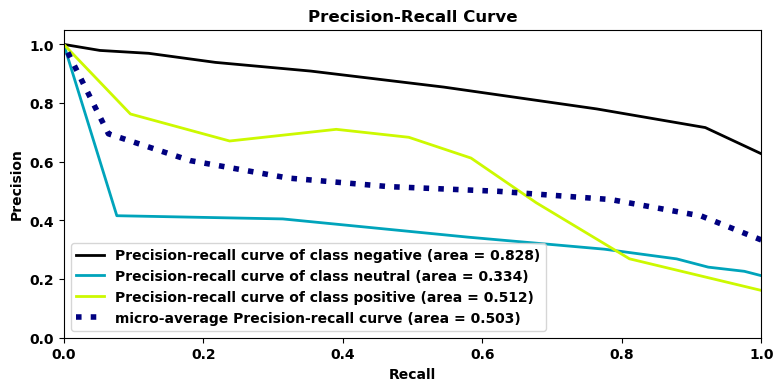

In [54]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = KNeighborsClassifier(n_neighbors=7)

model.fit(X_train_count, y_train)

y_pred_proba = model.predict_proba(X_test_count)
    
plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [55]:
y_pred = knn.predict(X_test_count)
knn_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
knn_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
knn_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

## Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1) # class_weight="balanced"
# overfittinge karsi en etkin parametre max_depth
# agac sayisi 100; yuksek olmasi iyi skor verse de cok time consumingdir.
rf.fit(X_train_count, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

In [57]:
print("RF MODEL")
eval(rf, X_train_count, X_test_count)

RF MODEL
[[1797    9   26]
 [ 511   70   37]
 [ 230    8  233]]
Test_Set
              precision    recall  f1-score   support

    negative       0.71      0.98      0.82      1832
     neutral       0.80      0.11      0.20       618
    positive       0.79      0.49      0.61       471

    accuracy                           0.72      2921
   macro avg       0.77      0.53      0.54      2921
weighted avg       0.74      0.72      0.66      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.74      1.00      0.85      7327
     neutral       0.97      0.21      0.34      2473
    positive       0.92      0.63      0.75      1883

    accuracy                           0.77     11683
   macro avg       0.88      0.61      0.65     11683
weighted avg       0.82      0.77      0.73     11683



In [58]:
model = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]
# overfittinh yok; skorlar cok yuksek

test_accuracy          0.710435
train_accuracy         0.773194
test_precision-neg     0.700333
train_precision-neg    0.742400
test_recall-neg        0.982121
train_recall-neg       0.997437
test_f1-neg            0.817608
train_f1-neg           0.851224
dtype: float64

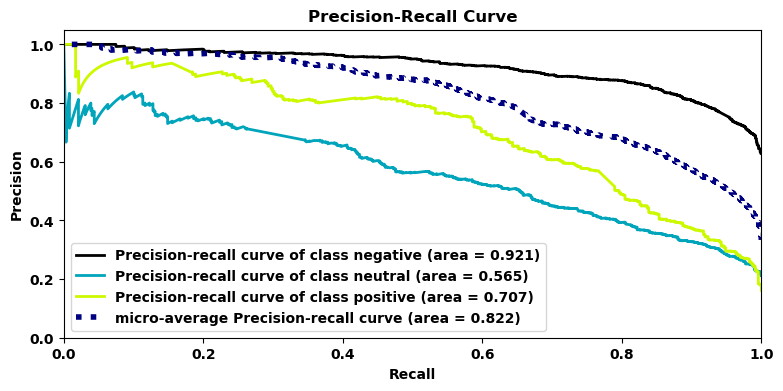

In [59]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1)

model.fit(X_train_count, y_train)

y_pred_proba = model.predict_proba(X_test_count)
    
plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [60]:
y_pred = rf.predict(X_test_count)
rf_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
rf_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
rf_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

### Balance Random Forest

In [61]:
# balance ile nasil olurdu:

rf = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_count, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=40, n_jobs=-1,
                       random_state=42)

In [62]:
print("RF MODEL BALANCED")
eval(rf, X_train_count, X_test_count)
# notr ve pozitif overfit olmus; negatif skorlari dusmus

RF MODEL BALANCED
[[1481  284   67]
 [ 155  403   60]
 [  59  109  303]]
Test_Set
              precision    recall  f1-score   support

    negative       0.87      0.81      0.84      1832
     neutral       0.51      0.65      0.57       618
    positive       0.70      0.64      0.67       471

    accuracy                           0.75      2921
   macro avg       0.69      0.70      0.69      2921
weighted avg       0.77      0.75      0.76      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.97      0.86      0.91      7327
     neutral       0.64      0.91      0.75      2473
    positive       0.88      0.81      0.84      1883

    accuracy                           0.86     11683
   macro avg       0.83      0.86      0.83     11683
weighted avg       0.89      0.86      0.87     11683



## Ada Boost

In [63]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_count, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [64]:
print("Ada MODEL")
eval(ada, X_train_count, X_test_count)

Ada MODEL
[[1568  194   70]
 [ 213  339   66]
 [  94   77  300]]
Test_Set
              precision    recall  f1-score   support

    negative       0.84      0.86      0.85      1832
     neutral       0.56      0.55      0.55       618
    positive       0.69      0.64      0.66       471

    accuracy                           0.76      2921
   macro avg       0.69      0.68      0.69      2921
weighted avg       0.75      0.76      0.75      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.87      0.89      0.88      7327
     neutral       0.62      0.62      0.62      2473
    positive       0.78      0.70      0.74      1883

    accuracy                           0.80     11683
   macro avg       0.76      0.74      0.75     11683
weighted avg       0.80      0.80      0.80     11683



In [65]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.761790
train_accuracy         0.802505
test_precision-neg     0.845375
train_precision-neg    0.868687
test_recall-neg        0.856009
train_recall-neg       0.883687
test_f1-neg            0.850587
train_f1-neg           0.876121
dtype: float64

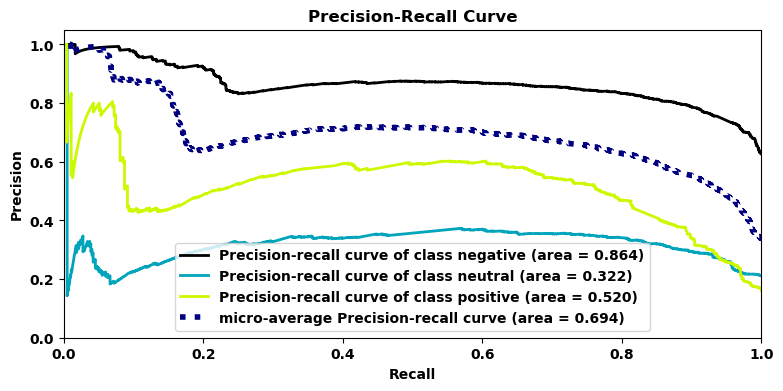

In [66]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = AdaBoostClassifier(n_estimators= 500, random_state = 42)

model.fit(X_train_count, y_train)

y_pred_proba = model.predict_proba(X_test_count)
    
plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [67]:
y_pred = ada.predict(X_test_count)
ada_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
ada_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
ada_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

## TF-IDF

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [69]:
tf_idf_vectorizer = TfidfVectorizer(preprocessor=cleaning, min_df=3, max_df=0.9)
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

# preprocessor hyper-parametrese yukarıda tanımladığımız cleaning fonksiyonunu vererek temizlik işlemini TfidfVectorizer
# dönüşüm algortiması içerisinde yaptırabiliyoruz.
# min_df = 3    --> corpusumda 3'den daha az document'da (yorumda) geçen tokenleri ignore et.
# max_df = 1000 --> corpusumda 1000'den daha fazla document'da (yorumda) geçen tokenleri ignore et.

# max_df = 0.95 --> corpusumdaki yorumların en az %95'inde geçen tokenleri ignore et
# min_df olarak 2,3 gibi, max_df 0.95 ve üzeri değerler tercih edilebilir.

# max_features = 1500 --> corpusumda en sık kullanılan ilk 1500 feature (tokeni) dikkate al diğerlerini ignore et.

# ngram, textimizdeki kalıpların (isim tamlaması, sıfat tamlaması vb) daha iyi öğrenilmesi için kullanılır.
# Çok güzel bir TV yorumu için;
# ngram = 1 olarak tüm tokenler 1'er 1'er ayrışır. Çok, güzel, bir, TV
# ngram = 2 olarak tüm tokenler 2'şer 2'şer ayrışır. Çok güzel, güzel bir, bir TV
# bgram = 3 olarak tüm tokenler 3'er 3'er ayrışır. Çok güzel bir, güzel bir TV
# ngram_range = (1, 3) tüm tokenler ngram 1, 2 ve 3'e göre 1'er 1'er, 2'şer 2'şer ve 3'er 3'er tokenlerine ayrılır
# ngram_range = (1, 4) tüm tokenler ngram 1, 2, 3 ve 4'e göre 1'er 1'er, 2'şer 2'şer, 3'er 3'er ve 4'er 4'er tokenlerine ayrılır

In [70]:
X_train_tf_idf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names_out())

,aa,aadvantage,abc,ability,able,aboard,abq,absolute,absolutely,absurd,abt,abysmal,ac,accept,acceptable,accepted,accepting,access,accident,accommodate,accommodating,accommodation,accomplished,according,account,...,yay,yea,yeah,year,yell,yelled,yelling,yep,yes,yesterday,yet,yo,york,youd,youll,young,youre,youve,yr,yuma,yup,yvr,yyz,zero,zone
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.421067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11678,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11679,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11680,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11681,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Comparisons  TF-IDF

## Naive Bayes

In [72]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB # ikisini de denedik, Multinomial daha iyi
# alpha default 1 en iyi skoru verdigi icin degistirmeyecegiz bu data icin

nb = MultinomialNB()
nb.fit(X_train_tf_idf,y_train)

# NB'te overfitting olusa ve alpha yi buyuterek cozemezsek class weight veya sample_weight yaparak overfittingi gidermeye
# calisiriz

MultinomialNB()

In [73]:
print("NB MODEL")
eval(nb, X_train_tf_idf, X_test_tf_idf)

NB MODEL
[[1797   29    6]
 [ 426  168   24]
 [ 251   29  191]]
Test_Set
              precision    recall  f1-score   support

    negative       0.73      0.98      0.83      1832
     neutral       0.74      0.27      0.40       618
    positive       0.86      0.41      0.55       471

    accuracy                           0.74      2921
   macro avg       0.78      0.55      0.59      2921
weighted avg       0.75      0.74      0.70      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.75      0.99      0.85      7327
     neutral       0.85      0.35      0.49      2473
    positive       0.92      0.51      0.65      1883

    accuracy                           0.78     11683
   macro avg       0.84      0.61      0.67     11683
weighted avg       0.80      0.78      0.75     11683



In [74]:
model = MultinomialNB()
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.730551
train_accuracy         0.773232
test_precision-neg     0.720490
train_precision-neg    0.749605
test_recall-neg        0.979937
train_recall-neg       0.988900
test_f1-neg            0.830371
train_f1-neg           0.852783
dtype: float64

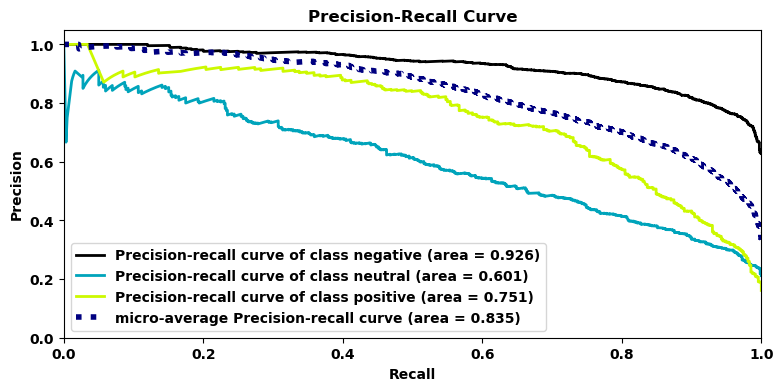

In [75]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = MultinomialNB()

model.fit(X_train_tf_idf, y_train)

y_pred_proba = model.predict_proba(X_test_tf_idf)
    
plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [76]:
y_pred = nb.predict(X_test_tf_idf)
nb_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
nb_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
nb_tfidf_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

## Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C=0.4, max_iter=1000)
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.4, max_iter=1000)

In [78]:
print("LOG MODEL")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL
[[1753   54   25]
 [ 332  259   27]
 [ 143   57  271]]
Test_Set
              precision    recall  f1-score   support

    negative       0.79      0.96      0.86      1832
     neutral       0.70      0.42      0.52       618
    positive       0.84      0.58      0.68       471

    accuracy                           0.78      2921
   macro avg       0.78      0.65      0.69      2921
weighted avg       0.78      0.78      0.76      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.82      0.97      0.89      7327
     neutral       0.82      0.53      0.64      2473
    positive       0.88      0.62      0.72      1883

    accuracy                           0.82     11683
   macro avg       0.84      0.71      0.75     11683
weighted avg       0.83      0.82      0.81     11683



In [79]:
model = LogisticRegression(C=0.4, max_iter=1000)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.771036
train_accuracy         0.820442
test_precision-neg     0.776515
train_precision-neg    0.812270
test_recall-neg        0.959464
train_recall-neg       0.976192
test_f1-neg            0.858310
train_f1-neg           0.886718
dtype: float64

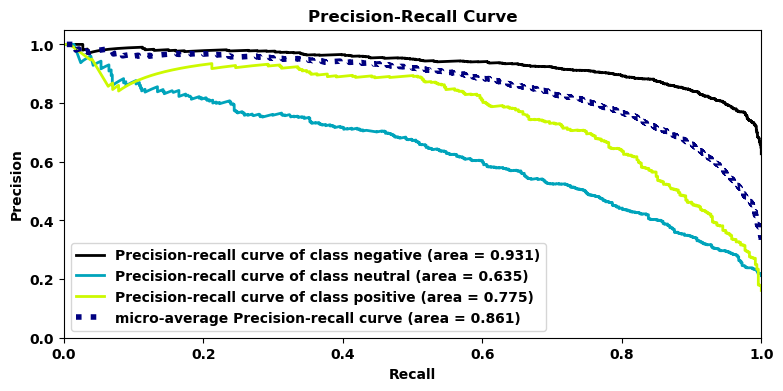

In [80]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = LogisticRegression(C=0.4, max_iter=1000)

model.fit(X_train_tf_idf, y_train)

y_pred_proba = model.predict_proba(X_test_tf_idf)
    
plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [81]:
y_pred = log.predict(X_test_tf_idf)
log_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
log_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
log_tfidf_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

### Balanced Logistic Regression

In [82]:
log = LogisticRegression(C=0.4, max_iter=1000, class_weight="balanced")
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.4, class_weight='balanced', max_iter=1000)

In [83]:
print("LOG MODEL BALANCED")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL BALANCED
[[1446  300   86]
 [ 120  423   75]
 [  36   75  360]]
Test_Set
              precision    recall  f1-score   support

    negative       0.90      0.79      0.84      1832
     neutral       0.53      0.68      0.60       618
    positive       0.69      0.76      0.73       471

    accuracy                           0.76      2921
   macro avg       0.71      0.75      0.72      2921
weighted avg       0.79      0.76      0.77      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.94      0.81      0.87      7327
     neutral       0.61      0.80      0.70      2473
    positive       0.75      0.85      0.79      1883

    accuracy                           0.81     11683
   macro avg       0.77      0.82      0.79     11683
weighted avg       0.84      0.81      0.82     11683



## SVM

In [84]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.1) # c =.1 ile overfittingi giderebildik
svc.fit(X_train_tf_idf,y_train)

LinearSVC(C=0.1)

In [85]:
print("SVC MODEL")
eval(svc, X_train_tf_idf, X_test_tf_idf)

SVC MODEL
[[1738   65   29]
 [ 324  254   40]
 [ 124   53  294]]
Test_Set
              precision    recall  f1-score   support

    negative       0.80      0.95      0.87      1832
     neutral       0.68      0.41      0.51       618
    positive       0.81      0.62      0.71       471

    accuracy                           0.78      2921
   macro avg       0.76      0.66      0.69      2921
weighted avg       0.77      0.78      0.76      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.83      0.97      0.90      7327
     neutral       0.83      0.56      0.67      2473
    positive       0.87      0.68      0.76      1883

    accuracy                           0.84     11683
   macro avg       0.84      0.74      0.78     11683
weighted avg       0.84      0.84      0.83     11683



In [86]:
model = LinearSVC(C=0.1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.781992
train_accuracy         0.836962
test_precision-neg     0.790388
train_precision-neg    0.831361
test_recall-neg        0.954550
train_recall-neg       0.974341
test_f1-neg            0.864710
train_f1-neg           0.897188
dtype: float64

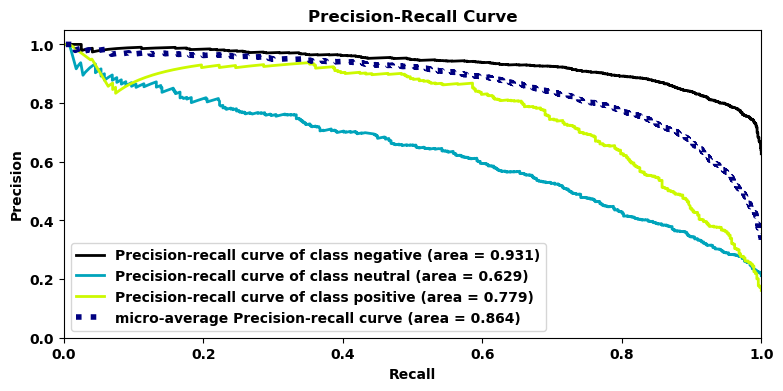

In [87]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = LinearSVC(C=0.1)

model.fit(X_train_tf_idf, y_train)

decision_function = model.decision_function(X_test_tf_idf)
    
plot_precision_recall(y_test, decision_function)
plt.show();

In [88]:
y_pred = svc.predict(X_test_tf_idf)
svc_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
svc_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
svc_tfidf_AP_neg = average_precision_score(y_test_dummies["negative"], decision_function[:, 0])

## KNN

In [89]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_tf_idf,y_train)

KNeighborsClassifier(n_neighbors=7)

In [90]:
print("KNN MODEL")
eval(knn, X_train_tf_idf, X_test_tf_idf)

KNN MODEL
[[ 285 1530   17]
 [  55  533   30]
 [  26  322  123]]
Test_Set
              precision    recall  f1-score   support

    negative       0.78      0.16      0.26      1832
     neutral       0.22      0.86      0.35       618
    positive       0.72      0.26      0.38       471

    accuracy                           0.32      2921
   macro avg       0.58      0.43      0.33      2921
weighted avg       0.65      0.32      0.30      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.97      0.95      0.96      7327
     neutral       0.57      0.92      0.71      2473
    positive       0.88      0.26      0.41      1883

    accuracy                           0.83     11683
   macro avg       0.81      0.71      0.69     11683
weighted avg       0.87      0.83      0.82     11683



In [91]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.305835
train_accuracy         0.781664
test_precision-neg     0.770584
train_precision-neg    0.969514
test_recall-neg        0.133058
train_recall-neg       0.867409
test_f1-neg            0.225772
train_f1-neg           0.889206
dtype: float64

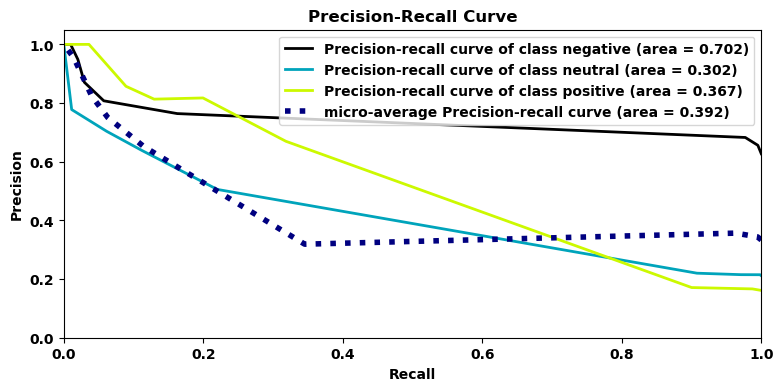

In [92]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = KNeighborsClassifier(n_neighbors=7)

model.fit(X_train_tf_idf, y_train)

y_pred_proba = model.predict_proba(X_test_tf_idf)
    
plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [93]:
y_pred = knn.predict(X_test_tf_idf)
knn_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
knn_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
knn_tfidf_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

## RandomForest

In [94]:
rf = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

In [95]:
print("RF MODEL")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL
[[1804    7   21]
 [ 527   60   31]
 [ 249    7  215]]
Test_Set
              precision    recall  f1-score   support

    negative       0.70      0.98      0.82      1832
     neutral       0.81      0.10      0.17       618
    positive       0.81      0.46      0.58       471

    accuracy                           0.71      2921
   macro avg       0.77      0.51      0.52      2921
weighted avg       0.74      0.71      0.64      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.73      1.00      0.85      7327
     neutral       0.98      0.21      0.34      2473
    positive       0.94      0.59      0.72      1883

    accuracy                           0.76     11683
   macro avg       0.88      0.60      0.64     11683
weighted avg       0.82      0.76      0.72     11683



In [96]:
model = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.708723
train_accuracy         0.767155
test_precision-neg     0.696766
train_precision-neg    0.734950
test_recall-neg        0.987307
train_recall-neg       0.998059
test_f1-neg            0.816959
train_f1-neg           0.846530
dtype: float64

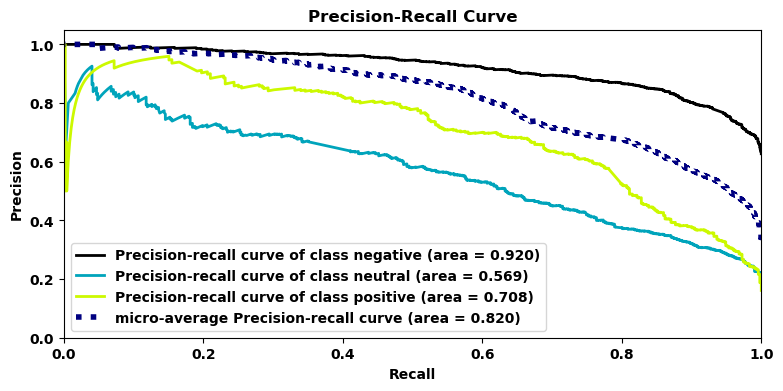

In [97]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)

model.fit(X_train_tf_idf, y_train)

y_pred_proba = model.predict_proba(X_test_tf_idf)
    
plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [98]:
y_pred = rf.predict(X_test_tf_idf)
rf_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
rf_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
rf_tfidf_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

### Balanced Random Forest

In [99]:
rf = RandomForestClassifier(100, max_depth=15, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_jobs=-1,
                       random_state=42)

In [100]:
print("RF MODEL BALANCED")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL BALANCED
[[1327  425   80]
 [ 130  424   64]
 [  39  126  306]]
Test_Set
              precision    recall  f1-score   support

    negative       0.89      0.72      0.80      1832
     neutral       0.43      0.69      0.53       618
    positive       0.68      0.65      0.66       471

    accuracy                           0.70      2921
   macro avg       0.67      0.69      0.66      2921
weighted avg       0.76      0.70      0.72      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.93      0.75      0.83      7327
     neutral       0.50      0.80      0.62      2473
    positive       0.73      0.71      0.72      1883

    accuracy                           0.75     11683
   macro avg       0.72      0.75      0.72     11683
weighted avg       0.81      0.75      0.77     11683



## Ada Boost

In [101]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_tf_idf, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [102]:
print("Ada MODEL")
eval(ada, X_train_tf_idf, X_test_tf_idf)

Ada MODEL
[[1548  226   58]
 [ 206  358   54]
 [  97   77  297]]
Test_Set
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      1832
     neutral       0.54      0.58      0.56       618
    positive       0.73      0.63      0.68       471

    accuracy                           0.75      2921
   macro avg       0.70      0.68      0.69      2921
weighted avg       0.76      0.75      0.75      2921

Train_Set
              precision    recall  f1-score   support

    negative       0.86      0.88      0.87      7327
     neutral       0.62      0.63      0.62      2473
    positive       0.83      0.72      0.77      1883

    accuracy                           0.80     11683
   macro avg       0.77      0.74      0.75     11683
weighted avg       0.80      0.80      0.80     11683



In [103]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.739537
train_accuracy         0.799091
test_precision-neg     0.824646
train_precision-neg    0.855639
test_recall-neg        0.838952
train_recall-neg       0.875620
test_f1-neg            0.831689
train_f1-neg           0.865509
dtype: float64

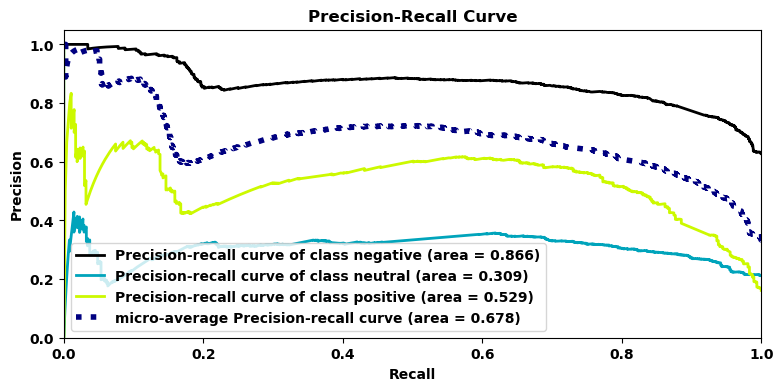

In [104]:
from scikitplot.metrics import plot_roc, plot_precision_recall

model = AdaBoostClassifier(n_estimators= 500, random_state = 42)

model.fit(X_train_tf_idf, y_train)

y_pred_proba = model.predict_proba(X_test_tf_idf)
    
plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [105]:
y_pred = ada.predict(X_test_tf_idf)
ada_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
ada_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
ada_tfidf_AP_neg = average_precision_score(y_test_dummies["negative"], y_pred_proba[:, 0])

In [106]:
nb_AP_neg

0.9190427600454487

## Compare Scoring

In [107]:
compare = pd.DataFrame({"Model": ["NaiveBayes_count", "LogReg_count", "SVM_count", "KNN_count", "Random Forest_count", 
                                  "AdaBoost_count", "NaiveBayes_tfidf", "LogReg_tfidf", "SVM_tfidf", "KNN_tfidf", 
                                  "Random Forest_tfidf", "AdaBoost_tfidf"],
                        
                        "F1_Score_Negative": [nb_count_f1_neg[0], log_count_f1_neg[0], svc_count_f1_neg[0], knn_count_f1_neg[0],
                                             rf_count_f1_neg[0], ada_count_f1_neg[0], nb_tfidf_f1_neg[0], log_tfidf_f1_neg[0],
                                             svc_tfidf_f1_neg[0], knn_tfidf_f1_neg[0], rf_tfidf_f1_neg[0], ada_tfidf_f1_neg[0]],
                        
                        "Recall_Score_Negative": [nb_count_rec_neg[0], log_count_rec_neg[0], svc_count_rec_neg[0], 
                                                  knn_count_rec_neg[0], rf_count_rec_neg[0], ada_count_rec_neg[0], 
                                                  nb_tfidf_rec_neg[0], log_tfidf_rec_neg[0], svc_tfidf_rec_neg[0], 
                                                  knn_tfidf_rec_neg[0], rf_tfidf_rec_neg[0], ada_tfidf_rec_neg[0]],
                        
                        "Average_Precision_Score_Negative": [nb_AP_neg, log_AP_neg, svc_AP_neg, knn_AP_neg, rf_AP_neg,
                                                          ada_AP_neg, nb_tfidf_AP_neg, log_tfidf_AP_neg, svc_tfidf_AP_neg,
                                                           knn_tfidf_AP_neg, rf_tfidf_AP_neg, ada_tfidf_AP_neg]})

compare

,Model,F1_Score_Negative,Recall_Score_Negative,Average_Precision_Score_Negative
0,NaiveBayes_count,0.825777,0.979258,0.919043
1,LogReg_count,0.849057,0.957969,0.926714
2,SVM_count,0.863418,0.933406,0.932850
3,KNN_count,0.568359,0.418668,0.828427
4,Random Forest_count,0.822426,0.980895,0.920544
5,AdaBoost_count,0.845967,0.855895,0.863816
6,NaiveBayes_tfidf,0.834649,0.980895,0.925883
7,LogReg_tfidf,0.863547,0.956878,0.931240
8,SVM_tfidf,0.865107,0.948690,0.931401
9,KNN_tfidf,0.259327,0.155568,0.701613


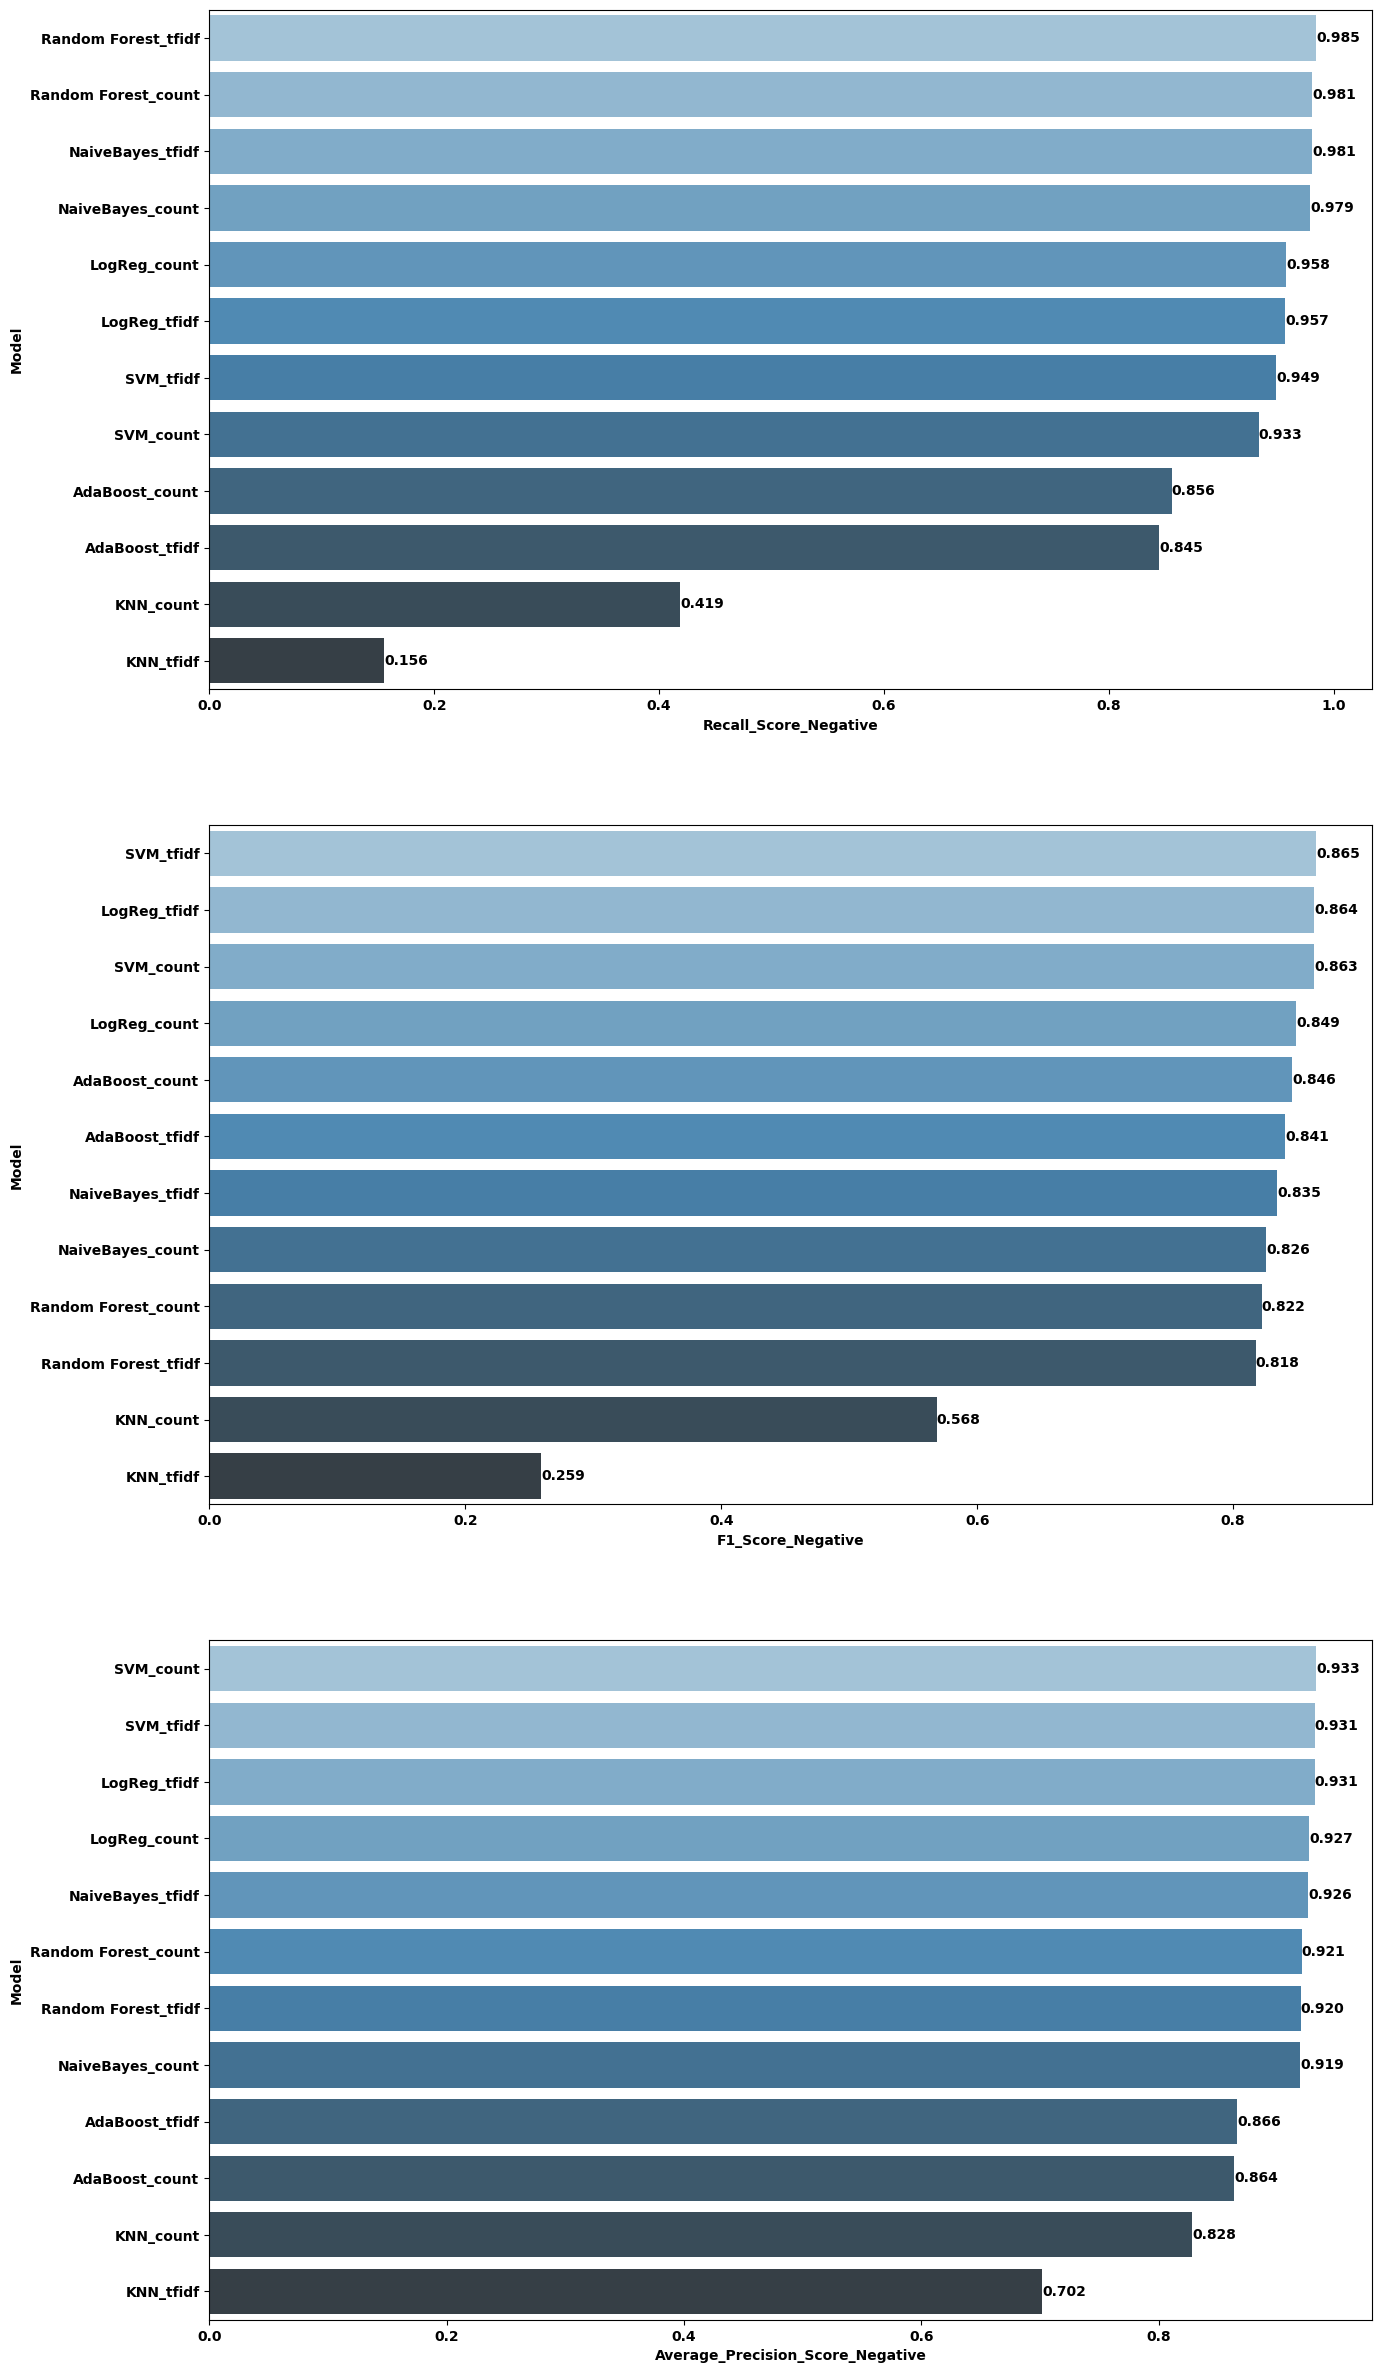

In [108]:
plt.figure(figsize=(15,30))
plt.subplot(311)
compare = compare.sort_values(by="Recall_Score_Negative", ascending=False)
ax=sns.barplot(x="Recall_Score_Negative", y="Model", data=compare, palette="Blues_d")            
ax.bar_label(ax.containers[0], fmt="%.3f")

plt.subplot(312)
compare = compare.sort_values(by="F1_Score_Negative", ascending=False)
ax=sns.barplot(x="F1_Score_Negative", y="Model", data=compare, palette="Blues_d")
ax.bar_label(ax.containers[0],fmt="%.3f")


plt.subplot(313)
compare = compare.sort_values(by="Average_Precision_Score_Negative", ascending=False)
ax=sns.barplot(x="Average_Precision_Score_Negative", y="Model", data=compare, palette="Blues_d")
ax.bar_label(ax.containers[0],fmt="%.3f")
plt.show();

# hernekadar RF ve NB recall scorları daha yüksek olsa da F1 scorları daha düşük buda bize bu modellerin precision
# scorlarının logreg veya SVM'ye nispeten daha düşük olduğunu gösterir.

# Bizim için tekbaşıan recall'un çok yüksek olması önemli değil. Recall ile birlikte precisionın da olabildiğince yüksek
# olması gerekli. Bu sebeple logreg tf-idf ile devam edeceğiz.

# svm ve logreg de hem recall hem f1ler yuksek. peki hangiai: SVM daha yavas; svm'de katsayilar 
# olmadigi icin yorum yapamiyoruz, svm'de feature selection yok. Log regde bunlarin hepsi var
# dolayisiyla svm eger logregden cok daha iyi skor vermiyorsa 2sinden logregi terc

# 10 kisi 5i hasta 5i saglikli. recall 1.0, precision 0.1 demek; tum hepsine hasta demis model ve 5 gercegi yakalamis
# ama saglikli bir model degil aslinda. dolayisiyla precision da yuksek olmali; bu nedenle f1'i de takip ederiz

# ornegin istenmeyen eposta modelinde precision; covid testinde recall daha onemlidir. ama 2sini de yuksek tutmak en iyisi

## For New Tweets, prediction with pipeline


In [109]:
from sklearn.pipeline import Pipeline

In [110]:
pipe = Pipeline([('tfidf',TfidfVectorizer(preprocessor=cleaning, min_df=3)),
                 ('log',LogisticRegression(C=0.4, max_iter=1000))])

In [111]:
X.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [112]:
pipe.fit(X, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3,
                                 preprocessor=<function cleaning at 0x00000196CEF04CA0>)),
                ('log', LogisticRegression(C=0.4, max_iter=1000))])

## Prediction

In [113]:
tweet = "it was not the worst flight i have ever been."
tweet = pd.Series(tweet) # modeli serielerlerle egittik, bu nedenle prediction da series ile verilmeli
pipe.predict(tweet)

array(['negative'], dtype=object)

In [114]:
tweet = "I don't like flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [115]:
tweet = "I like flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

# neden bilemediğini aşağıda analiz edeceğiz.

array(['negative'], dtype=object)

In [116]:
tweet = "it is amazing flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

In [117]:
tweet = "it isn't amazing flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

# neden bilemediğini aşağıda analiz edeceğiz.

array(['positive'], dtype=object)

In [118]:
tweet = "I don't think I'll ever use American Airlines anymore"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [119]:
tweet = "ok flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['neutral'], dtype=object)

In [120]:
# neden yukarda bariz hatalar yapti isn't ve I like flight'ta
tweets = cleaning_text
tweets.head()

0                                                 said
1         plus youve added commercial experience tacky
2         didnt today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
Name: text, dtype: object

In [121]:
y

0         neutral
1        positive
2         neutral
3        negative
4        negative
           ...   
14599    positive
14600    negative
14601     neutral
14602    negative
14603     neutral
Name: airline_sentiment, Length: 14604, dtype: object

In [122]:
for i in enumerate(tweets):
    print(i)

# öncelikle herbir tweet/yoruma karşılık gelecek şekilde enumerate fonksiyonu ile index numaralarını atamak istiyorum. 
# Burda elde ettiğim index numaraları ile yorumlara karşılık gelen targetın classını görmek istiyorum.
# örnek, (1, 'plus youve added commercial experience tacky') 1'inci index'teki 'plus youve added commercial experience tacky'
# yorumunun classını görmek için y[1] kullanarak yorumun hangi classa ait olduğunu görebileceğim.
# Bu işlemi neden yaptığımızı aşağıda kuracağımız for döngülerinde daha iyi anlıyacağız.

(0, 'said')
(1, 'plus youve added commercial experience tacky')
(2, 'didnt today must mean need take another trip')
(3, 'really aggressive blast obnoxious entertainment guest face amp little recourse')
(4, 'really big bad thing')
(5, 'seriously would pay flight seat didnt playing really bad thing flying va')
(6, 'yes nearly every time fly vx ear worm go away')
(7, 'really missed prime opportunity men without hat parody')
(8, 'well')
(9, 'amazing arrived hour early youre good')
(10, 'know suicide second leading cause death among teen')
(11, 'lt pretty graphic much better minimal iconography')
(12, 'great deal already thinking trip amp havent even gone trip yet p')
(13, 'im flying sky u take away travel')
(14, 'thanks')
(15, 'schedule still mia')
(16, 'excited first cross country flight lax mco ive heard nothing great thing virgin america')
(17, 'flew nyc sfo last week couldnt fully sit seat due two large gentleman either side help')
(18, 'flying')
(19, 'know would amazingly awesome plea

In [123]:
len(y)

14604

In [124]:
counter = 0
for i,j in enumerate(tweets):
    if "dont like" in j and y[i]=="negative":
        counter += 1
print(counter)

# içerisinde "dont like" tokenleri birlikte geçen ve aynı zamanda olumsuz olan yorumların sayısını bulmak istiyorum
# Bu şekilde datamda eğitim için yeterli veri var mı? yok mu? daha iyi anlayabileceğim.
# Model 14 tane "dont like"dan öğrenebilir. Bu kapsamda model "I dont like flight" yorumunu negative olarak doğru bilmiş.

14


In [125]:
counter = 0
for i,j in enumerate(tweets):
    if "like" in j and y[i]=="positive":
        counter += 1
print(counter)

# şimdi yukardaki I like flight yorumunu neden bilemediğine bakalım.
# like tokeninin geçtiği toplam 66 tane olumlu yorum varken. Aşağıda da gördüğümüz gibi olumsuz yorumlarda 303 defa geçiyor.
# model like tokeni çoğunlukla olumsuz yorumlarda geçtiği için tahminini olumsuz olarak yapmış.

66


In [126]:
counter = 0
for i,j in enumerate(tweets):
    if "like" in j and y[i]=="negative":
        counter += 1
print(counter)

303


In [127]:

counter = 0
for i,j in enumerate(tweets):
    if "isnt amazing" in j and y[i]=="negative":
        counter += 1
print(counter)

# şimdi yukardaki it isn't amazing flight yorumunu neden bilemediğine bakalım.
# isnt amazing tokenleri birlikte olumsuz yorumlarda hiç kullanılmadığından, olumlu yorumlarda 78 defa geçen amazing tokenine
# göre bir tahminde bulunup yoruma olumlu demiş.

0


In [128]:
counter = 0
for i,j in enumerate(tweets):
    if "amazing" in j and y[i]=="positive":
        counter += 1
print(counter)

# bu nednele data cok buyuk olmali ki daha buyuk corpusla daha iyi calissin

78


## WordCloud - Repetition of Words

## Collect Words

In [49]:
tweets = cleaning_text
tweets

0                                                     said
1             plus youve added commercial experience tacky
2             didnt today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14599                   thank got different flight chicago
14600    leaving minute late flight no warning communic...
14601                        please bring american airline
14602    money change flight dont answer phone suggesti...
14603    ppl need know many seat next flight plz put u ...
Name: text, Length: 14604, dtype: object

In [50]:
all_words = " ".join(tweets)

In [51]:
all_words[:100]

'said plus youve added commercial experience tacky didnt today must mean need take another trip reall'

## Create Word Cloud

In [132]:
#pip install wordcloud
#conda install -c conda-forge wordcloud

In [47]:
from wordcloud import WordCloud

# Wordcloud, metin dosyalarındaki kelime sıklığını görsel olarak temsil etmek için kullanılır. Bu görsel temsilde, metin 
# dosyasındaki kelimelerin görsel büyüklüğü, sıklığına göre belirlenir. Böylece, metin dosyasındaki en sık kullanılan kelimeler
# en büyük olarak görüntülenir. 

# bir sosyal medya hesabından toplanan yorumların içeriğini analiz etmek için wordcloud kullanabilir. Bu yorumlarda en sık geçen
# tokenler dikkate alınarak hangi konunun tartışıldığı veya ön plana çıktığı analiz edilebilir.

In [48]:
worldcloud = WordCloud(background_color="white", max_words =250)

# arka plan rengi beyaz olacak şekilde ve corpusta en sık geçen ilk 250 tokenden bir görsel oluştur.

In [52]:
worldcloud.generate(all_words)

# generate komutu ile yukarda verdiğimiz talimatlara göre datamızda en sık geçen ilk 250 token belirlenir.

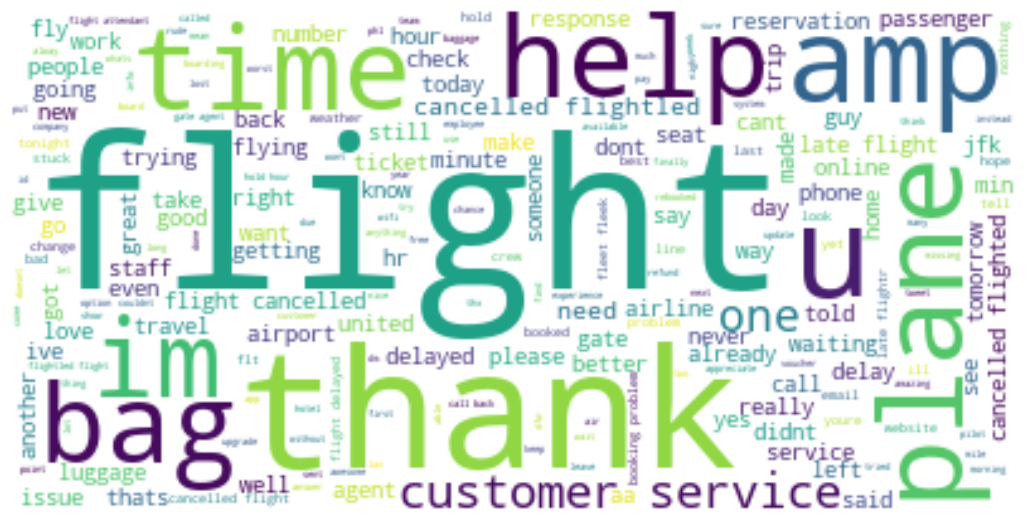

In [53]:
import matplotlib.pyplot as plt # görselliştirmek için matplotlib kütüphanesi kullanılıyor.
plt.figure(figsize = (13,13))
plt.imshow(worldcloud, interpolation="bilinear")
plt.axis("off")
plt.show()